In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree, metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
from io import StringIO  
from IPython.display import Image  
import pydotplus
from graphviz import Source
from IPython.display import SVG

from sb_utils import save_file

Capstone #2 EDA

The goal of this Capstone is to build a model to predict the number of days that patient is admitted to the ICU of Beth Israel Medical Center.  The data description does not indicate which ICU was used, so we will assume its a combination of all the ICU specializations.  The dataset contains quantifiable pysiological data collected at their time of admission.  This prediction could be useful to insurance companies to better understand the cost of patient care, to hospitals to understand how to budget thier resources for different patients, or to physicians to better understand how differnent features impact patient recovery.

Features Selection: There are 25 phyiological features in our data (26 features including the month of admission), stored in the variable `health_data`, so the main goal of EDA will be to determine which are the most interesting and likely to be predictive of the length of the hospital stay.  It is also likely that there is colinearity between features, as physioligical markers are often chaging together.  An obvious example of this is thta when a person performs exercise, pulse and respiration increae together.  

Categorical or Continuous Length of Stay: A secondary question to investigate is how to express the length of stay.  Should it be expressed as a vontinuous variable allowing fractions of days in our prediction?  Should it be catergorical with each day a new catergory? Or should we do ranges, such as 1-2 days, 3-5 days etc?  To get some insight into this, we will look a deeper look at the data in the `lengthofstay` column and see if there are any insights with how it tends to correleate with other variables.


In [3]:
#Read the LengthOfStay.csv file into the variable health_data
health_data = pd.read_csv('LengthOfStay_data_cleaned.csv')

In [4]:
health_data.head()

,eid,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,psychother,...,bmi,pulse,respiration,secondarydiagnosisnonicd9,facid,lengthofstay,readmission_cat,readmission_int,admission_month,admission_year
0,82815,M,0,0,0,0,0,0,0,0,...,30.118187,92,6.5,0,B,2,0,0,1,2012
1,99368,M,0,0,1,0,0,0,0,0,...,29.007914,76,6.4,5,C,3,0,0,1,2012
2,91182,M,0,0,0,0,0,0,0,0,...,26.734935,66,7.2,1,B,1,0,0,1,2012
3,83267,M,0,0,1,0,0,0,0,0,...,28.077883,61,6.0,3,C,3,0,0,1,2012
4,2956,F,0,0,0,0,0,0,0,0,...,32.619871,71,6.5,1,B,8,5+,5,1,2012


First, I will look at the correlation between non-binary features and length of stay.  Most of these features are continuous, while two are categorical.

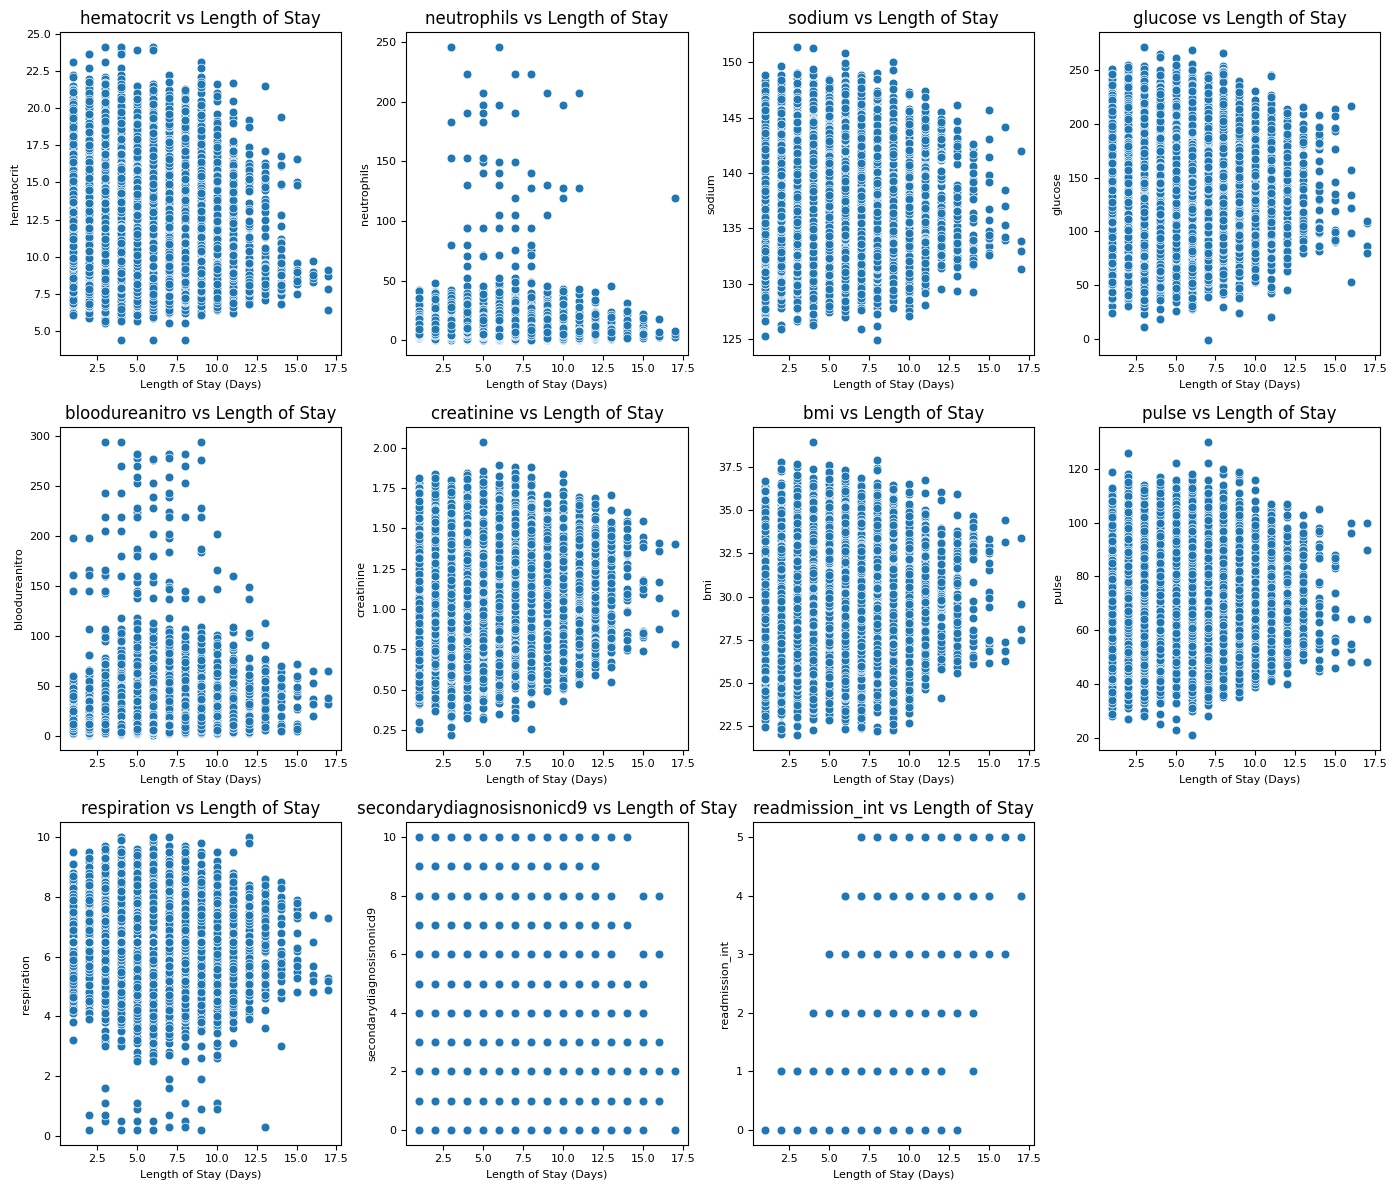

In [5]:
fig, axes = plt.subplots(3, 4, figsize=(14, 12))

# Flatten axes for easy looping
axes = axes.flatten()
vars_to_plot = ['hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine',
       'bmi', 'pulse', 'respiration', 'secondarydiagnosisnonicd9', 'readmission_int']
for ax, v in zip(axes, vars_to_plot):
    sns.scatterplot(data=health_data, x='lengthofstay', y=v, ax=ax, s=40)
    ax.set_title(f'{v} vs Length of Stay', fontsize=12)
    ax.set_ylabel(v, fontsize=8)
    ax.set_xlabel("Length of Stay (Days)", fontsize=8)
    ax.tick_params(axis='both', labelsize=8)

# If there are empty cells, hide them
for i in range(len(vars_to_plot), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Two main observations:  
1) The only variable which seems to correlate with length of stay is the number of readmissions.
2) Many of the features are making the same shape, where the spread of the data shrinks as the length of stay increases, such that the patients who are in the hosptial the longest have values close to what looks like the median of the spread.  

Also, there are some patients with extremely low respiration, which does not seem possible.  Keep that in mind to see if we should drop those patients as we go.

Next, we will look at how the binary features correspond to length of stay, with 0 meaning the patient does not have said condition, while 1 means the patient does have the condition.

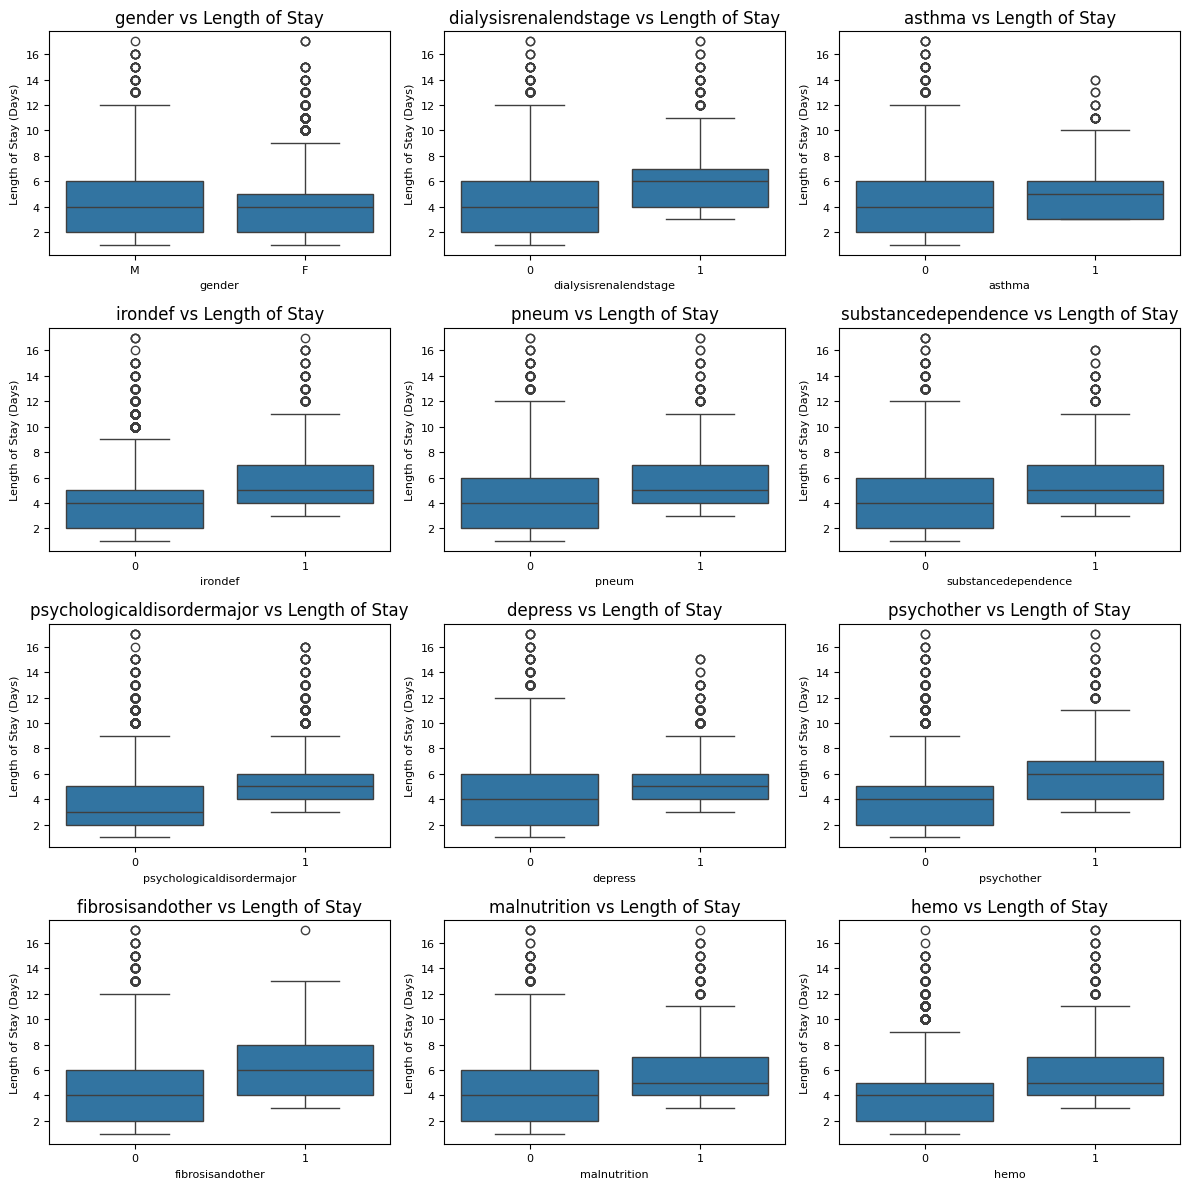

In [6]:
fig, axes = plt.subplots(4, 3, figsize=(12,12))

# Flatten axes for easy looping
axes = axes.flatten()
vars_to_plot = ['gender', 'dialysisrenalendstage', 'asthma', 'irondef', 'pneum',
       'substancedependence', 'psychologicaldisordermajor', 'depress',
       'psychother', 'fibrosisandother', 'malnutrition', 'hemo' ]
for ax, v in zip(axes, vars_to_plot):
    sns.boxplot(data=health_data, x=v, y='lengthofstay', ax=ax)
    ax.set_title(f'{v} vs Length of Stay', fontsize=12)
    ax.set_xlabel(v, fontsize=8)
    ax.set_ylabel("Length of Stay (Days)", fontsize=8)
    ax.tick_params(axis='both', labelsize=8)

# If there are empty cells, hide them
for i in range(len(vars_to_plot), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Here, there are a number of features where the median length of stay is higher in the patients that have the condition versus those that do not have the condition.  However, I'm not certain how useful these trends will be when predicting length of stay over the entire range of hospital stays for the following reasons:  
1) The difference between the median length of stay for most features which show a difference is usually only 1-2 days. Will this be enough to separate patients accross the entire range of hospital stays?
2) The medians are for all features, both those that have the condition and those patients that do not, are at most 6 days.  This could be very useful for predicting shorter stays, but what about longer stays?
3) The patients who have hospital 10+ or 12+ days (depending on the feature) are outliers in all boxplots, both for patients that have the condition and those that do not.  If we were only concerned with patients staying less than 10 days, this would be fine.  However, one could argue that finding the patients that stay 10+ days and separating them from patients that have shorter stays is the most useful thing the model can help our stackholders.

That said, the features that seem the most interesting based on these boxplots are `['dialysisrenalendstage', 'irondef', 'pneum', 'substancedependence', 'psychologicaldisordermajor', 'psychother', 'malnutrition', 'hemo']`.  It is not possible at this point to distinguish between them.  `'gender'` can be discounted from the model, and `fibrosisandother` maybe should also be discounted as there are very few 1 values (something we saw during data wrangling).

Given that the patients above 10+ days tend to be outliers in these plots, in the next step I'd like to try to look at the data differently to see if there are features that have different summary statisistics for patients that have these longer stays.  

In [7]:
bins = [0, 5, 9, 999]   
labels = ['1-5', '6-9', '10+']

health_data['LoS_cat'] = pd.cut(
    health_data['lengthofstay'],
    bins=bins,
    labels=labels,
    right=True
)

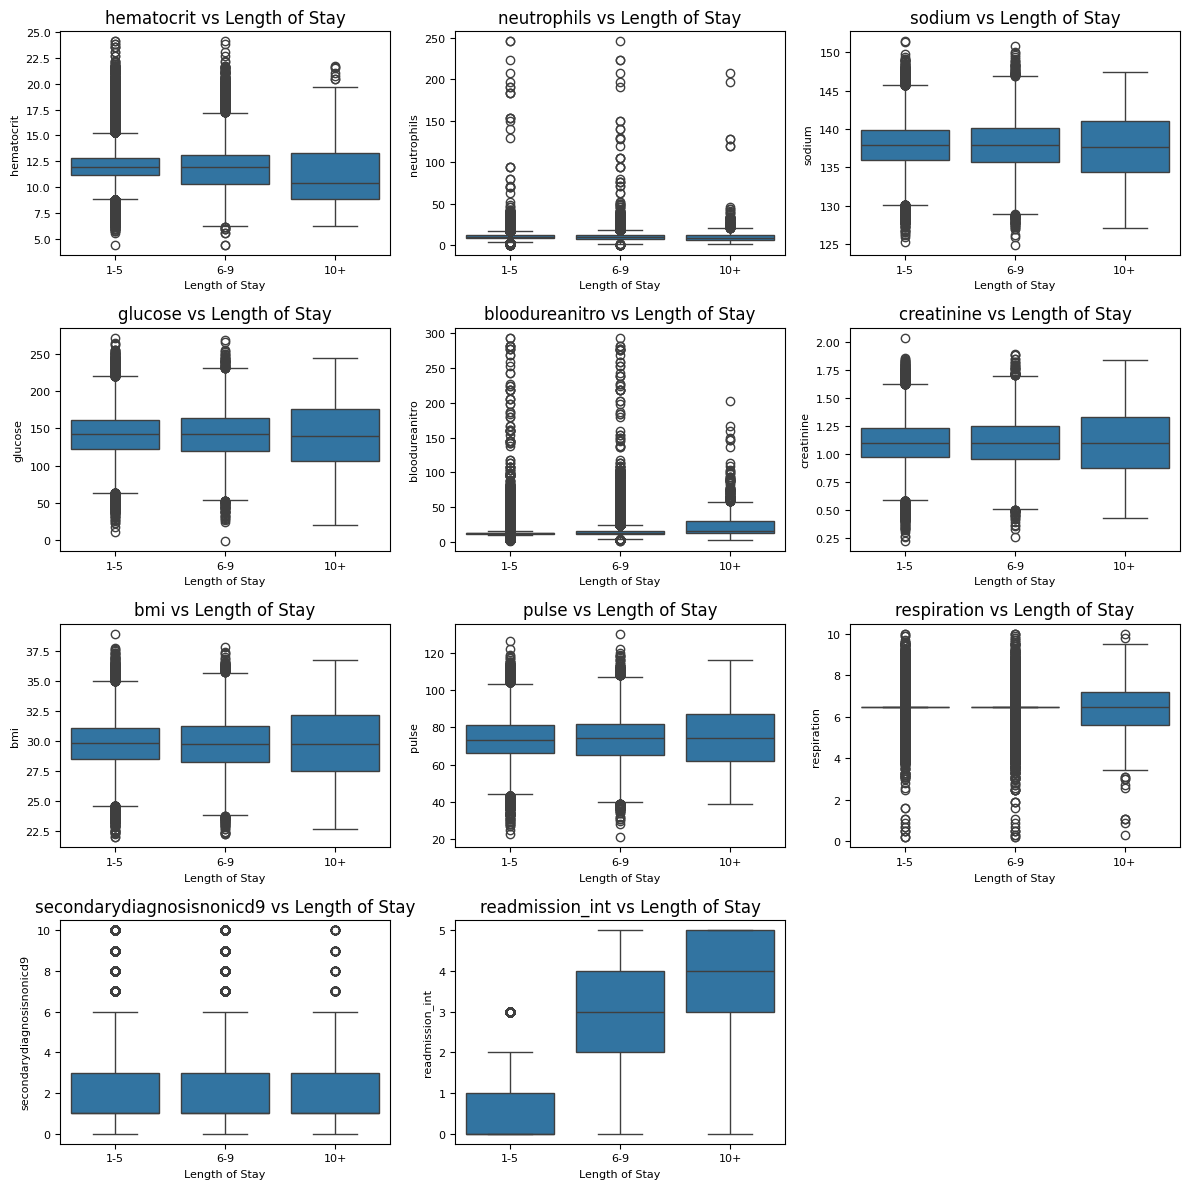

In [8]:

fig, axes = plt.subplots(4, 3, figsize=(12,12))

axes = axes.flatten()
vars_to_plot = ['hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine',
       'bmi', 'pulse', 'respiration', 'secondarydiagnosisnonicd9', 'readmission_int']
for ax, v in zip(axes, vars_to_plot):
    sns.boxplot(data=health_data, x='LoS_cat', y=v, ax=ax)
    ax.set_title(f'{v} vs Length of Stay', fontsize=12)
    ax.set_ylabel(v, fontsize=8)
    ax.set_xlabel("Length of Stay", fontsize=8)
    ax.tick_params(axis='both', labelsize=8)

# If there are empty cells, hide them
for i in range(len(vars_to_plot), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

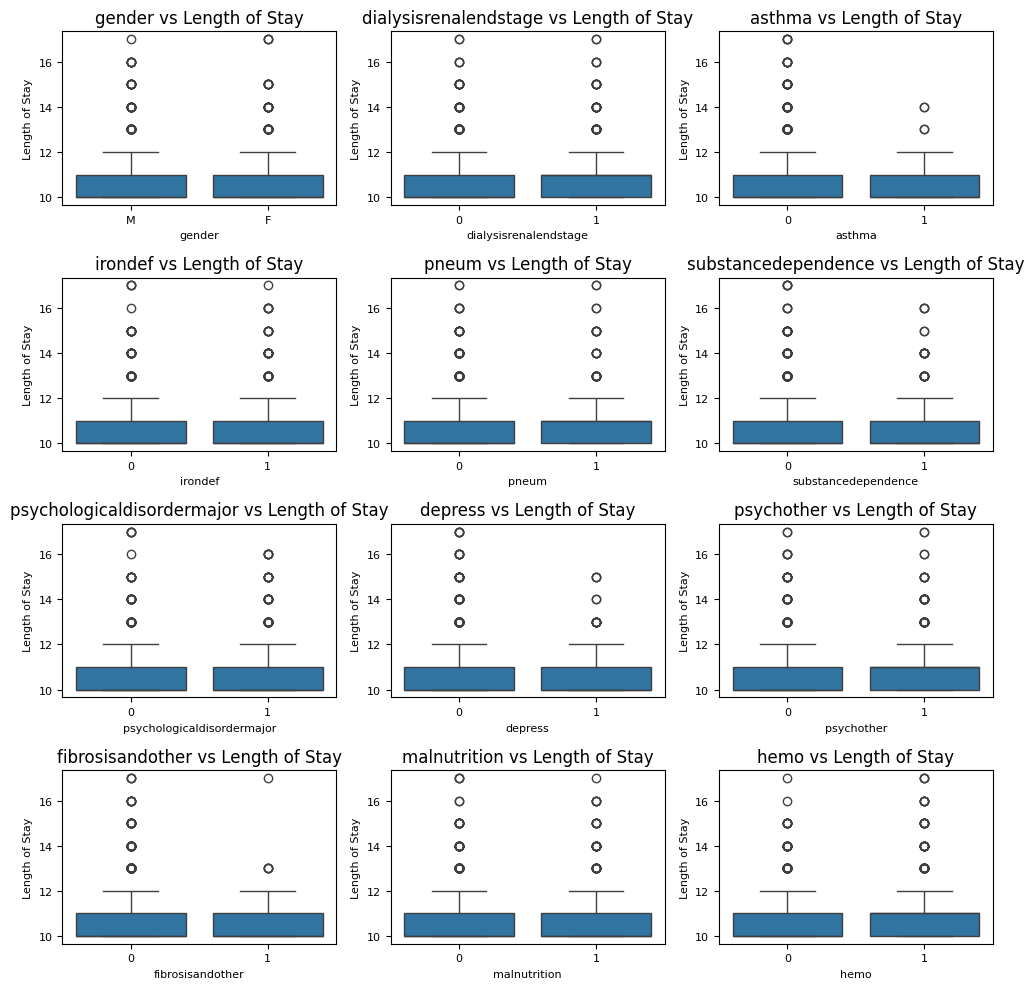

In [9]:
health_10 = health_data[health_data['lengthofstay'] >= 10]
fig, axes = plt.subplots(4, 3, figsize=(10,10))

# Flatten axes for easy looping
axes = axes.flatten()
vars_to_plot = ['gender', 'dialysisrenalendstage', 'asthma', 'irondef', 'pneum', 'substancedependence', 'psychologicaldisordermajor', 'depress',
       'psychother', 'fibrosisandother', 'malnutrition', 'hemo' ]
for ax, v in zip(axes, vars_to_plot):
    sns.boxplot(data=health_10, x=v, y='lengthofstay', ax=ax)
    ax.set_title(f'{v} vs Length of Stay', fontsize=12)
    ax.set_xlabel(v, fontsize=8)
    ax.set_ylabel('Length of Stay', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)

# If there are empty cells, hide them
for i in range(len(vars_to_plot), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Unfortunatly, looking specifically at the patients with 10+ days of admission did not yeild any clearer answers, other than reaffirming that the number of readmissions is higher in patients with longer stays.  I will leave this analysis in place in case it is useful later.

I find it surprising that none of the physiological measures show a positive correlation with length of stay, especially things that are typically associated with very poor health like high blood urea nitrogen or end stage renal disease.  To the contrary, many of the features show that patients who have longer stays have values closer to the median (as described above) rather than the more extreme values seen in patients where shorter stays.  I don't have an explanation for this.

These observations suggest to me that tree based models will be the most useful for this type of data where there are few linear relationships.  While I haven't studied these models yet, my rudimentary understanding suggests to me that these models would be more successful at using decision points to pull out these median values that describe patients with longer stays.

Regarding feature selection, it's clear that the number of readmissions will be a deciding feature.  Beyond that, I cannot discount very many features from our starting set based on these results.  I think the best approach will be to leave them in place (unless I find colinearity in the next section) when I begin building the model and see which ones the pipeline chooses.

Before moving on to colinearity, I will look for a correlation between the month of admission and length of stay.  During Data Wrangling, I made a new column containing the month of the year that the patient was admitted a catergorical variable.

Text(0.5, 1.0, 'Mean Length of Stay by Month of Admission')

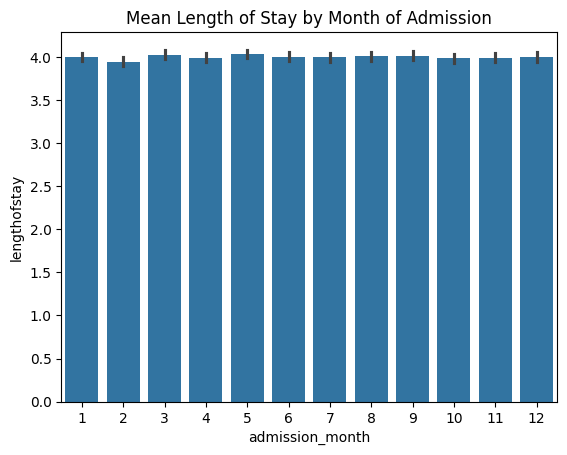

In [10]:
sns.barplot(health_data, x='admission_month', y='lengthofstay', estimator='mean')
plt.title('Mean Length of Stay by Month of Admission')

There does not seem to be any effect of month on length of stay, so this column can be discounted.

I will now move on to look for colinearity between features using a heatmap.

<Axes: >

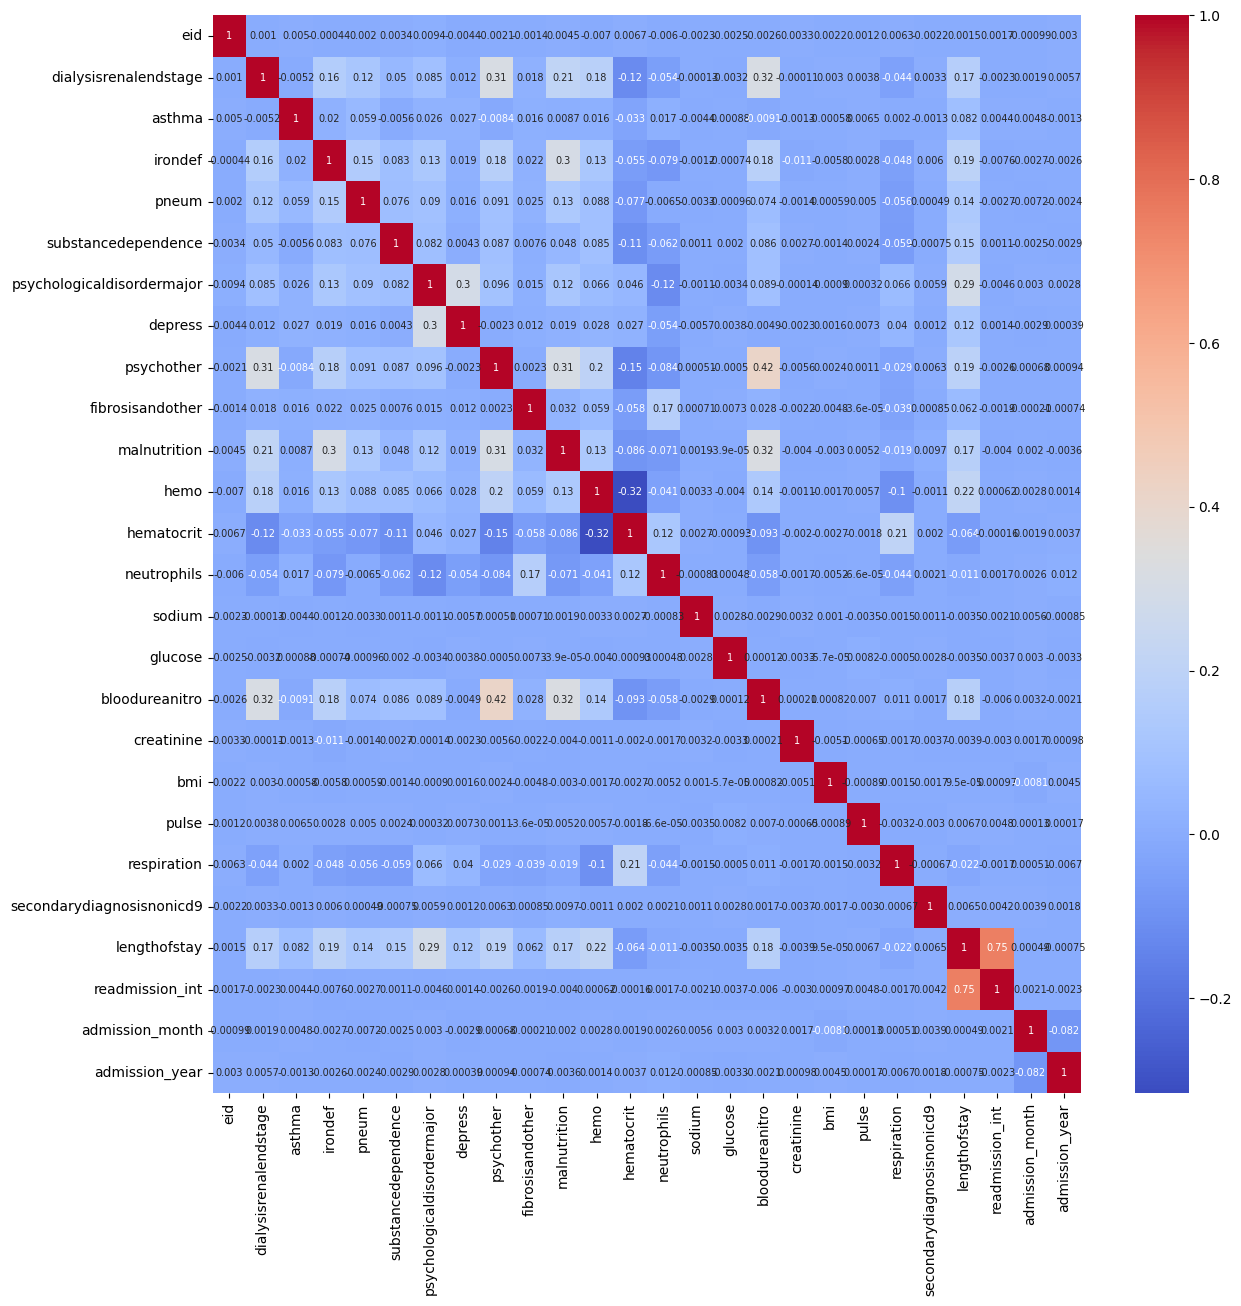

In [11]:
plt.figure(figsize=(14, 14))
sns.heatmap(health_data.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', annot_kws={"size": 7})

Some observations from the heatmap:  
1) We see that the number of readmissions is the only feature with a remarkable correlation (0.75) wwith length of stay, which is expected based on the previous analysis.
2) There are no other correlations in the data set above 0.5, so we don't need to worry about colinearity after all.
3) I am surprised that there isn't any colinearity.  What about the pulse and respiration example?  Some of these data points 'should' be colinear. If I were working on this data set for a client, this would be cause to set up a meeeting with an SME and discuss this results.  I would want to know if they are also surprised by the lack of colonearity between the following features:
- pulse and respiration
- dialysis/end stage renal disease and blood urea nitrogen (BUN) or creatinine (BUN has a smaller correlation with renal disease than I would expect, while creatinine has none). Note the BUN and creatinine are the main readouts physicians use to asses kidney function.  
  
Not to belabor the point, I'll look at the scatterplots between these features that I expeacted to correlate.

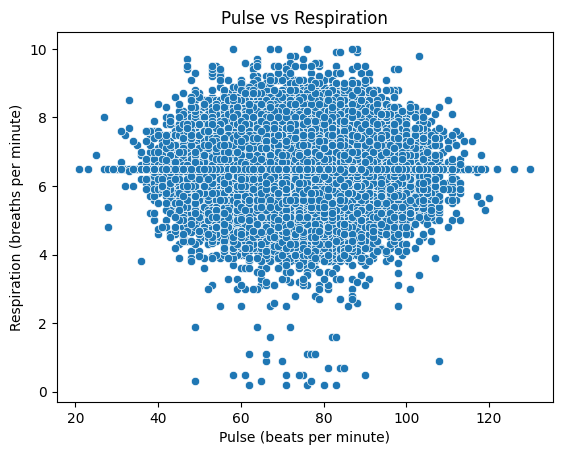

In [12]:
sns.scatterplot(health_data, x='pulse', y='respiration')
plt.title('Pulse vs Respiration')
plt.xlabel('Pulse (beats per minute)')
plt.ylabel('Respiration (breaths per minute)')
plt.show()

That's about as uncorrelated as it gets.  Again, this isn't what I expected the dataset to show, but there is no arguing with the plot.

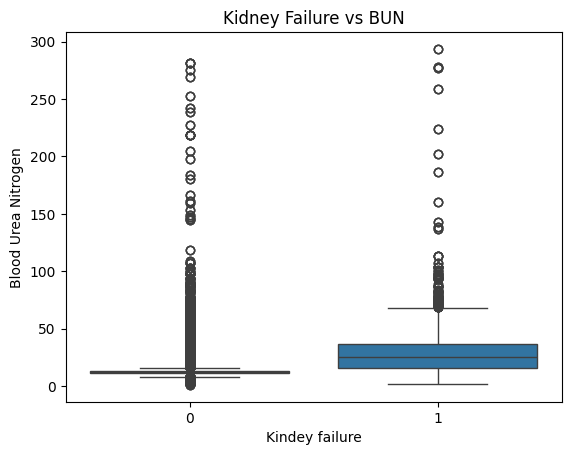

In [13]:
sns.boxplot(health_data, x='dialysisrenalendstage', y='bloodureanitro')
plt.title('Kidney Failure vs BUN')
plt.xlabel('Kindey failure')
plt.ylabel('Blood Urea Nitrogen')
plt.show()

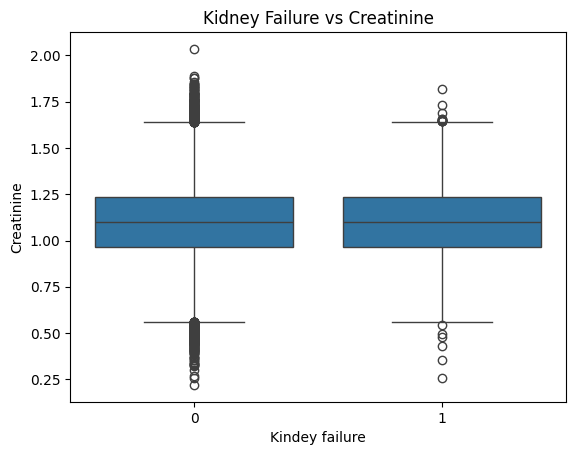

In [14]:
sns.boxplot(health_data, x='dialysisrenalendstage', y='creatinine')
plt.title('Kidney Failure vs Creatinine')
plt.xlabel('Kindey failure')
plt.ylabel('Creatinine')
plt.show()

As suggested by the heatmap, there is some correlation between kidney failure and BUN, but not creatinine. High BUN can also mean heart failure or dehydration, so those results seem acceptable.  I cannot undertand the lack of correlation between kidney failure and creatinine.  
The only explaination I can find is that normal creatinine levels varies by gender, wieght and age.  Physicians use these variables to calculte the GFR (Glomular Filtration Rate) to convert the creatinine levels into a more informative readout of kidney function.  As this data set does not include age or wieght, I cannot make this calculation for these patients.

Based on above findings, I will make a new version of the data table dropping the following columns which I do not think have any influence on length of stay.  
- admission month
- admission year
- LoS_cat
- readmission_cat (this column is essentially identicle to readmission_int and should have been removed during Data Wrangling)  

Other features such as sodium, glucose and bmi show no correlation, but exhibited the same data shape when plotted against length of stay as a scatterplot.  I am intrigued by this pattern and will leave these features in place for now.

In [15]:
health_data_final = health_data.drop(['admission_month', 'admission_year', 'LoS_cat', 'readmission_cat'], axis=1)

Given that I have predicted that this data set would be best modelled with a tree based approach, I will attempt to demonstrate this using a single Decision Tree.

In [17]:
health_data_final.columns


Index(['eid', 'gender', 'dialysisrenalendstage', 'asthma', 'irondef', 'pneum',
       'substancedependence', 'psychologicaldisordermajor', 'depress',
       'psychother', 'fibrosisandother', 'malnutrition', 'hemo', 'hematocrit',
       'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine',
       'bmi', 'pulse', 'respiration', 'secondarydiagnosisnonicd9', 'facid',
       'lengthofstay', 'readmission_int'],
      dtype='object')

In [20]:
# Make an explanatory variable called X, and a dependent variable called y
X = health_data_final.drop('lengthofstay', axis=1)
y = health_data_final['lengthofstay']
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=246) 

In [44]:
# Assign model to a variable, and ensure the max_depth parameter is set to 5
model_5 = tree.DecisionTreeRegressor(criterion ='squared_error' , random_state = 1234, max_depth=5)

# Do the fit, predict, and series transformations as before. 
model_5.fit(X_train, y_train)
y_pred = model_5.predict(X_test)
pd.Series(y_pred)
model_5

,criterion,'squared_error'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,1234
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


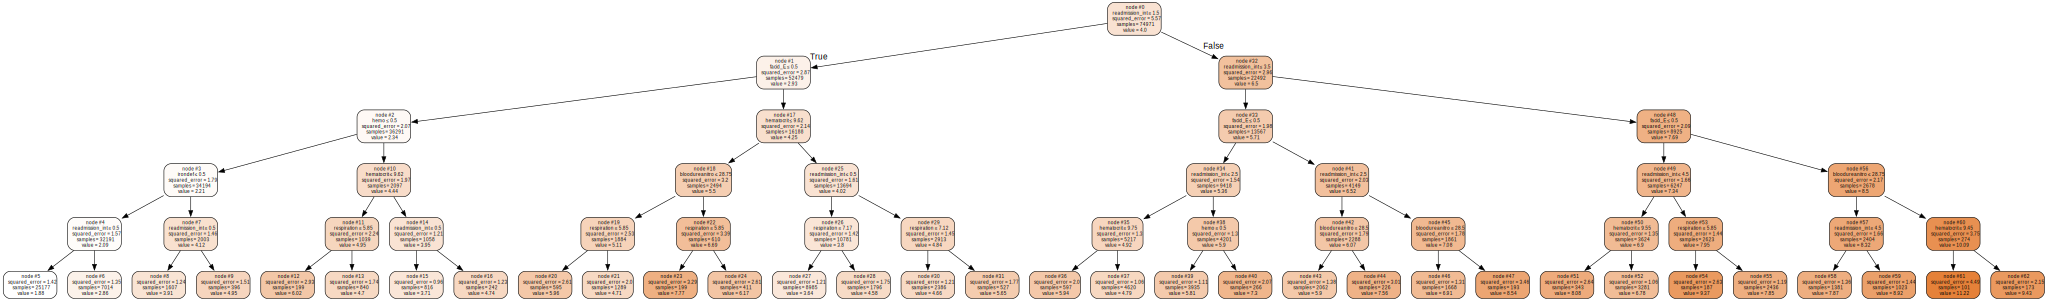

In [46]:
dot_data = StringIO()
dot = tree.export_graphviz(model_5, out_file=None, feature_names=X_train.columns, filled=True, rounded=True, special_characters=True, node_ids=True,
    proportion=False, precision=2)

dot = dot.replace(
    'node [shape=box',
    'node [shape=box, fontsize=8'
)
graph = Source(dot)
SVG(graph.pipe(format='svg'))

In [49]:
print("Squared Error Regressor Model - max depth 5")
print("R2:", metrics.r2_score(y_test,y_pred))
print("MSE:", metrics.mean_squared_error(y_test,y_pred))


Squared Error Regressor Model - max depth 5
R2: 0.7514837133934117
MSE: 1.3812730002893523


This looks pretty good for a first attempt at a single tree.  The model is picking out the features of the data the were found earlier, namely trend of longer admissions associated with more readmissions.

Out of curiosity, I'll do one more tree with a max depth of 7 and see how that changes the metrics.

In [51]:
# Assign model to a variable, and ensure the max_depth parameter is set to 10
model_7 = tree.DecisionTreeRegressor(criterion ='squared_error' , random_state = 1234, max_depth=7)
model_7.fit(X_train, y_train)
y_pred = model_7.predict(X_test)
pd.Series(y_pred)
model_7

,criterion,'squared_error'
,splitter,'best'
,max_depth,7
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,1234
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


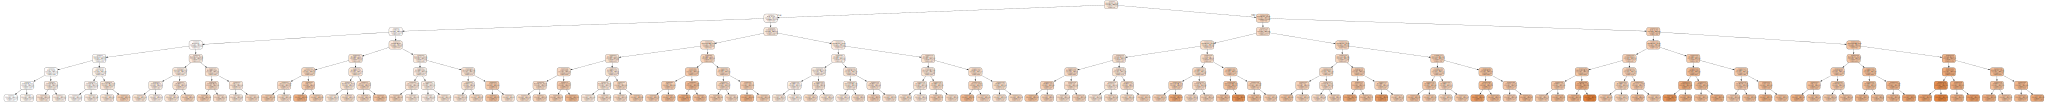

In [52]:
dot_data = StringIO()
dot = tree.export_graphviz(model_7, out_file=None, feature_names=X_train.columns, filled=True, rounded=True, special_characters=True, node_ids=True,
    proportion=False, precision=2)

dot = dot.replace(
    'node [shape=box',
    'node [shape=box, fontsize=8'
)
graph = Source(dot)
SVG(graph.pipe(format='svg'))

In [53]:
print("Squared Error Regressor Model - max depth 7")
print("R2:", metrics.r2_score(y_test,y_pred))
print("MSE:", metrics.mean_squared_error(y_test,y_pred))

Squared Error Regressor Model - max depth 7
R2: 0.7920197306626103
MSE: 1.15597063899243


OK, increasing the max depth to 7 had a small improvement in the R2 and MSE.  Clearly more advanced hyperparatmeter tuning, along with ensemble methods will be needed to improve the model in the next chapter of this project, but this start suggests that tree based is a promising way to go with this data set. 

In [54]:
# save the data to a new csv file
datapath = 'C:/Users/Ujval/OneDrive/Documents/GitHub/Springboard/Capstone_2'
save_file(health_data_final, 'LengthOfStay_EDA.csv', datapath)

A file already exists with this name.

Writing file.  "C:/Users/Ujval/OneDrive/Documents/GitHub/Springboard/Capstone_2\LengthOfStay_EDA.csv"


## Summary

In this notebook, I performed the EDA for the LengthOfStay_data_cleaned.csv dataset, which contains information on 100,000 patients admitted to the ICU for the purpose of predicting the length of their inpatient stay.

During EDA, the data set was examined for features which correlate to length of stay and for colinearity between features.

The most surprising thing found in this analysis was a lack of correlation between features or with the lateget length of stay.  Based on these results, if this were a project for a real client, I would recommend a meeting with an SME to determine if this lack of correlation between features makes sense to them, as it does not make sense to me.

## Summary of Observations
1) Number of readmissions was the only feature found to be correlated with length of stay, with a coeffient of 0.75.
2) Many of the continuous variables had the same shape to the data with plotted against length of stay in a scatterplot, in that the variance of the data decreased as length of stay increased and patients with longer stays all had values nearer the median.  In other words, extreme values indicated that patients had shorter admissions.  I don't know what to make of this from medical sense, but it is intriguing and may be useful information during model building.
3) No clinearity was found between features, which I find surprising froma medical sense.  Even features that logically should be colinear (pulse and respiration, or kindey failrue abd creatinine levels) had no or weak correlation in this data set.
4) An attempt was made to find defining characteristics for patients with admissions of 10+ days, but this was unsuccessful and the categorical column made for this purpose was removed from the data set.
5) Gender and month of admission had no bearing on length of stay and were removed from the data set.

## Modeling Recommendations

After going through this dataset, I predict that Regression models will by largely unsuccessful in favor of tree based models.  This is because the data lacks linear correlations, especially in the continuous variables, but does contain some clear branch points that could be used by modles like Random Forest.  Some examples of branch points could be "Does the patient have more than 2 readmissions?" or "Does the patient have an sodium level between 130-145 ?".

I tested this prediction my making a singel tree model using the DecisionTreeRegressor function and got 0.75 R2 and an MSE of 1.38 days with a max depth of 5, then got 0.79 R2 and an MSE of 1.15 days with a max depth of 7.  There is still much more to do, but this is a promising start before going into model building.

The final dataset was saved as `LengthOfStay_EDA.csv`.